In [11]:
import os, sys

import pymongo as pm
import numpy as np
import scipy.stats as stats
import pandas as pd
import json
import re
from io import BytesIO
from PIL import Image
import requests # this is to access the stim urls from the notebook
from IPython.display import SVG, display # need for showing stims with sketches side by side
import base64
import PIL


from bezier import curve
from svg.path import Path, Line, Arc, CubicBezier, QuadraticBezier, Close, parse_path

import matplotlib
from matplotlib import pylab, mlab, pyplot
import matplotlib.patches as mpatches
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('talk')
sns.set_style('white')
from matplotlib import rcParams

from IPython.display import clear_output
import importlib

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

# so dataframes don't get cut off in display:
#pd.set_option("display.max_rows", None, "display.max_columns", None)

### set up paths

In [12]:
# directory & file hierarchy
proj_dir = os.path.abspath('..')
analysis_dir = os.getcwd()
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
exp_dir = os.path.abspath(os.path.join(proj_dir,'experiments'))
sketch_dir = os.path.abspath(os.path.join(proj_dir,'sketches'))
gallery_dir = os.path.abspath(os.path.join(proj_dir,'gallery'))

## add helpers to python path
if os.path.join(proj_dir,'utils') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'utils'))   

def make_dir_if_not_exists(dir_name):   
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
    return dir_name

## create directories that don't already exist        
result = [make_dir_if_not_exists(x) for x in [results_dir,plot_dir,csv_dir,sketch_dir,gallery_dir]]

## add utils to python path
import sys
if os.path.join(proj_dir,'utils') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'utils'))
import utils

### establish connection to mongo
first thing you need to do is to establish an ssh tunnel (aka remote port forwarding) to the server, so that requests to the mongodb can be made "as if" the mongodb server is running on your local computer. Run this from the command line before you begin data analysis if you plan to fetch data from mongo:

ssh -fNL 27020:127.0.0.1:27017 USER@cogtoolslab.org

In [13]:
! ssh -fNL 27020:127.0.0.1:27017 sholt@cogtoolslab.org

In [14]:
# set vars 
auth = pd.read_csv(os.path.join(analysis_dir,'auth.txt'), header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'cogtoolslab.org'

# have to fix this to be able to analyze from local
import pymongo as pm
import socket
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1:27017')
db = conn['iterated_number']
coll = db['num8_shape4']

# which iteration name should we use?
iterationName = 'run6' #increment when needed
# this has previously been run1, then sandbox3, but switched to sandbox 3 for testing the url recording function


In [15]:
## here is what one of these records looks like
coll.find_one()


{'_id': ObjectId('5ea11f9677a5814e85793c69'),
 'iterationName': 'sandboxtest2',
 'gameid': '3601-22bb9a7f-f441-4ec3-a2ed-678cea977bbc',
 'time': 1587617686433.0,
 'trialNum': 1,
 'workerId': 'ATHO7Y5CT91O3',
 'assignmentId': '3U5NZHP4LV2Q6K2EN75E91NSKGVPHG',
 'intendedName': 'owl_5',
 'svgData': 'M97,104c50.95184,0 110.84203,-9.43865 155,20c6.35227,4.23484 35.54189,36.45811 25,47c-1.82059,1.82059 -2.92187,-0.575 -4,0c-44.57034,23.77085 -101.51569,42.65189 -152,45c-10.55139,0.49076 -39.53347,7.93307 -48,-9c-28.67466,-57.34933 51.55221,-127.99261 77,-69c28.33338,65.68192 -45.21961,130.94619 -84,72c-13.26402,-20.16131 -23.22808,-104.95727 28,-80c23.65797,11.52568 30.13693,49.37655 38,71c0.04431,0.12186 8.90106,26 15,26',
 'currStrokeNum': '1',
 'shiftKeyUsed': '0',
 'previous_score': '0',
 'previous_bonus_score': '0',
 'startStrokeTime': '1587617682284',
 'endStrokeTime': '1587617683600',
 'eventType': 'stroke'}

### Initialize dataframes

In [17]:
## trials
k = coll.find({'iterationName':iterationName, 'eventType':'clickedObj'})
k2 = coll.find({'iterationName':'run2', 'eventType':'clickedObj'})
k3 = coll.find({'iterationName':'run3', 'eventType':'clickedObj'})
k4 = coll.find({'iterationName':'run4', 'eventType':'clickedObj'})
k5 = coll.find({'iterationName':'run5', 'eventType':'clickedObj'})
K = pd.DataFrame(k)
K2 = pd.DataFrame(k2)
K3 = pd.DataFrame(k3)
K4 = pd.DataFrame(k4)
K5 = pd.DataFrame(k5)
K = K.append(K2, ignore_index=True).append(K3, ignore_index=True).append(K4, ignore_index=True).append(K5, ignore_index=True)
# ^ iterationName got changed unnecessarily several times; we want all data ranging from run2 to run6

## strokes
t = coll.find({'iterationName':iterationName, 'eventType':'stroke'})
t2 = coll.find({'iterationName':'run2', 'eventType':'stroke'})
t3 = coll.find({'iterationName':'run3', 'eventType':'stroke'})
t4 = coll.find({'iterationName':'run4', 'eventType':'stroke'})
t5 = coll.find({'iterationName':'run5', 'eventType':'stroke'})
T = pd.DataFrame(t)
T2 = pd.DataFrame(t2)
T3 = pd.DataFrame(t3)
T4 = pd.DataFrame(t4)
T5 = pd.DataFrame(t5)
T = T.append(T2, ignore_index=True).append(T3, ignore_index=True).append(T4, ignore_index=True).append(T5, ignore_index=True)
# ^ iterationName got changed unnecessarily several times; we want all data ranging from run2 to run6


## get list of valid game IDs (i.e, subject number)
from collections import Counter
game_dict = Counter(K['gameid']) ## get dictionary mapping gameIDs to number of sketches 
complete_gameids = [k for (k,v) in game_dict.items() if v==32] ## get gameids that contributed exactly the right number of sketches

## subset stroke/sketch dataframes by being complete AND also exclude practice
subset = True
if (subset and T['gameid'].nunique()!=len(complete_gameids)):
    T = T[(T['gameid'].isin(complete_gameids))].reset_index(drop=True)
    K = K[(K['gameid'].isin(complete_gameids))].reset_index(drop=True)
    
print('We have {} unique stroke records in all {} of our complete games.'.format(T.shape[0],len(complete_gameids)))
print('We have {} unique sketch records in all {} of our complete games.'.format(K.shape[0],len(complete_gameids)))

# save out to csv
T.to_csv(os.path.join(csv_dir,'photodraw_stroke_data.csv'),index=False)
K.to_csv(os.path.join(csv_dir,'photodraw_sketch_data.csv'),index=False)


## generate group dataframe and save out to file
importlib.reload(utils)
D = utils.generate_dataframe(coll, complete_gameids, iterationName, csv_dir)

# Turning things that can be numeric into numeric things
D = D.astype({'trialNum': 'float',
              'cardinality': 'float',
              'drawDuration': 'float',
              'outcome': 'float',
              'numStrokes': 'float',
              'meanPixelIntensity': 'float',
              'numCurvesPerSketch': 'float',
              'numCurvesPerStroke': 'float',
              'D1_Car': 'float',
              'D2_Car': 'float',
              'D3_Car': 'float'})

def GetArcLenData(df):
    """
    Thought having this measure might be helpful for naive quantitative analyses.
    
    This function requires the dataframe to have a ['svgString'] column to analyse.
    It returns the same dataframe, but with an extra column of 'stroke_len_means'.
    Currently just taking the total arc length of each stroke, and averaging them per sketch.
    
    If not already done, import Path, Arc, CubicBezier, and parse_path from svg.path
    Used this: https://pypi.org/project/svg.path/
    """
    stroke_len_means = []
    for row_num in range(len(df['svgString'])):
        stroke_lengths = []
        for stroke_num in range(len(df['svgString'][row_num])):
            stroke_length = 0
            for curve in parse_path(D['svgString'][row_num][stroke_num]):
                stroke_length += curve.length(error=1e-5)
            stroke_lengths.append(stroke_length)
        stroke_len_means.append(np.mean(stroke_lengths))
    new_df = df
    new_df['stroke_len_means'] = stroke_len_means
    return new_df

D = GetArcLenData(D)

# Keep track of which quarter of the experiment the trial happened in
D['quarter'] = np.ceil(D['trialNum']/8)
D = D.astype({'quarter': 'float'})
D['cardinality'] = D['cardinality'] + 1 #cardinalities are 0-indexed, which is ugly

D_backup = D #we are going to exclude data from D, so might as well back it up into another variable too


We have 3730 unique stroke records in all 22 of our complete games.
We have 704 unique sketch records in all 22 of our complete games.


In [8]:
## monitor how far along games-in-progress are
all_games = K['gameid'].unique()
num_games = len(all_games)
print('There are a total of {} unique gameids in mongo.'.format(num_games))

print('\n')
print('These are the games and how many trials have been completed so far:')
for name, group in K.groupby('gameid'):
    print('gameid: {} | number of trials : {}'.format(name, group.shape[0]))

There are a total of 67 unique gameids in mongo.


These are the games and how many trials have been completed so far:
gameid: 0074-988d4ee1-5766-47b5-bcbb-49a720aee30d | number of trials : 32
gameid: 0095-d4a81902-118c-4dda-bf91-6522bd3c1b7d | number of trials : 32
gameid: 0196-4a8ca8ea-c82c-4f36-af78-e3374d339786 | number of trials : 32
gameid: 0215-2671868a-4819-49c7-9d88-a41191b25eb3 | number of trials : 32
gameid: 0304-a93c4bf1-c4f9-46e4-b8a1-dd2359a31933 | number of trials : 32
gameid: 0532-734dfb32-c173-48df-bfa2-0decb357302b | number of trials : 32
gameid: 0646-33d71b5d-3800-4485-b05a-91338ba7bde8 | number of trials : 32
gameid: 0885-d57e4e9f-a2c5-4978-a12f-b219cafba17e | number of trials : 32
gameid: 1034-bd869e68-6b1e-41b8-b50b-98b16f6692a6 | number of trials : 32
gameid: 1135-f8a97bb7-107c-41c5-b871-7bc08ef01068 | number of trials : 32
gameid: 1178-fd0a52f9-110d-497c-91fc-4c5dfd21b8aa | number of trials : 32
gameid: 1372-60cdfd55-28bb-411c-b777-c51eaadee7a9 | number of trial

In [32]:
## TODO: hash 'workerId' so that we do not save actual workerIDs to file.

### render out all the sketches

In [9]:
importlib.reload(utils)
utils.render_images(K,data = 'pngString',
                    metadata = ['gameid','intendedName','trialNum','game_condition'],
                    out_dir = sketch_dir)

Done rendering 2144 images to /Users/alles/iterated_number/sketches.


### make sketch gallery (for complete games only)

In [48]:
importlib.reload(utils)
## actually render sketch gallery for each complete game
utils.render_sketch_gallery(complete_gameids,
                            D_backup,
                            sketch_dir = sketch_dir,
                            gallery_dir = gallery_dir,
                            num_trials = 32,
                            by_trialnum = True,
                            show_correct = True,
                            transpose=False)

Generating sketch gallery for participant: 4399-a6cebf27-430e-4f06-95e8-8073905aa3ab | 1 of 67
Generating sketch gallery for participant: 0196-4a8ca8ea-c82c-4f36-af78-e3374d339786 | 2 of 67
Generating sketch gallery for participant: 4423-063641e5-72aa-4053-bef9-3789d566fab3 | 3 of 67
Generating sketch gallery for participant: 1178-fd0a52f9-110d-497c-91fc-4c5dfd21b8aa | 4 of 67
Generating sketch gallery for participant: 8342-edf0aae6-04f1-4753-b910-1647f52ce424 | 5 of 67
Generating sketch gallery for participant: 5018-ef371cb8-5a88-490a-b67b-de4b77de3d02 | 6 of 67
Generating sketch gallery for participant: 3880-3184be49-687c-4cc1-ae09-d4fed1a8f5a8 | 7 of 67
Generating sketch gallery for participant: 8460-eb851b40-9c33-464c-b063-e21197a66936 | 8 of 67
Generating sketch gallery for participant: 6096-45b1ca17-5b6f-4763-b392-5035dbd8ef94 | 9 of 67
Generating sketch gallery for participant: 7144-e442c1e6-9730-4af1-8108-456484ed3ee7 | 10 of 67
Generating sketch gallery for participant: 8369-7

## Analysis things

### Cleaning

In [18]:
# Get the data out onto a CSV so we can do some analysis in R

# First clean it up by removing games that we have to exclude. Get dud games manually:
dud_games = ["6769-3ee1e797-2c5b-4441-8d67-5ccd1c6b9a73",    #number
             "8369-76e6f73d-922a-4aca-b98a-8c96026aa48a",    #number
             "1372-60cdfd55-28bb-411c-b777-c51eaadee7a9",    #shape
             "2949-1e579088-8493-4c07-873c-7bd6d00685e3",    #shape
             "7197-6d1f3fda-040a-455c-aef0-279ba9aef053",    #shape
             "9237-4cc76e85-9955-4cef-b03c-5c68f46321ca",    #shape
             "1947-29382ba4-5747-456d-ba8b-276812fc1fb3"]    #shape

# now remove them
for dud in dud_games:
    D = D[D.gameID != dud]

# the names of the games we want to keep:
kosher_games = [game for game in complete_gameids if game not in dud_games]

# Export the csv. This is what the R script will look at
D.to_csv('all_data.csv')


### Visualizing

In [7]:
## if we want to change superficial elements of figures, this is a way to do that
# rcParams['font.family'] = 'serif'
# rcParams['font.sans-serif'] = ['Tahoma']


In [8]:
# Looking visually to see if the spatial distributions of sketcher target matches the sketches
def show_targ_and_sketch(ID,trialnum,disp=True):
    """
    Just a function that plots a sketch (specified by the gameID and trial number) with its target stimulus.
    Output of this function is the image showing both side by side.
    """
    game = D[D.gameID == ID]
    trial = game[game.trialNum == trialnum]
    stim_url = trial['Targ_s_Url'].values[0]
    get_stim = requests.get(stim_url)
    stim = Image.open(BytesIO(get_stim.content))
    
    get_sketch = trial['png'].values[0]
    sketch = Image.open(BytesIO(base64.b64decode(get_sketch)))
    
    sketch = sketch.resize((100,100))
    stim = stim.resize((100,100))
    
    images = [sketch,stim]
    widths, heights = zip(*(i.size for i in images))
    total_width = max(widths)
    max_height = sum(heights)
    whole_trial = Image.new('RGBA', (total_width, max_height),color='white')
    y_offset = 0
    for im in images:
        whole_trial.paste(im, (0,y_offset))
        y_offset += im.size[1]
    if disp == True:
        display(whole_trial)
    return whole_trial

def show_targs_sketches_game(ID,save=False):
    """
    This function takes in a gameID and shows sketches and their targets for every trial, side by side.
    Optionally, it will save this output into a png.
    """
    whole_game = Image.new('RGBA', (3200, 200),color='white')
    for trial_num in np.arange(1,33):
        trial = show_targ_and_sketch(ID,trial_num,disp=False)
        whole_game.paste(trial,(trial_num*100-100,0))
        
    if save == True:
        condition = D[D.gameID == ID]['Game_Condition'].values[0]
        fname = str(condition) + '_' + ID + "_s_s"
        
        out_dir = './sketches_stims'
        # create the out_dir if it does not already exist
        if not os.path.exists(out_dir): 
            os.makedirs(out_dir)
            
        # now save the image out to that directory
        if not os.path.exists(os.path.join(out_dir,fname+'.png')):
            print('Rendering…', fname + '.png') 
            whole_game.save(os.path.join(out_dir,fname+'.png'),'PNG')
            
    return whole_game

for game_id in kosher_games:
    print("Now generating sketch + stim display for ",game_id)
    show_targs_sketches_game(game_id,save=True)


NameError: name 'kosher_games' is not defined

### analyze performance (accuracy and RT)

In [284]:
acc_table = D.groupby('gameID')['outcome'].mean().reset_index()
acc_table['outcome'].mean()


0.9203125

## Figures for 1YPaper

In [ ]:
# Figure 1 was just showing written number systems. No quantitative data
# Figure 3 was showing qualitative data, i.e. sketches and stimuli. No quantitative

# First want to generate dataframes under specific restrictions to look at
# just number games or just shape games
df_num = D.loc[D['Game_Condition'] == 'number']
df_aml = D.loc[D['Game_Condition'] == 'shape']

# just games that are number or shape, and a specific quarter of those games
dn1 = df_num.loc[df_num['quarter'] == 1.0]
dn2 = df_num.loc[df_num['quarter'] == 2.0]
dn3 = df_num.loc[df_num['quarter'] == 3.0]
dn4 = df_num.loc[df_num['quarter'] == 4.0]

da1 = df_aml.loc[df_aml['quarter'] == 1.0]
da2 = df_aml.loc[df_aml['quarter'] == 2.0]
da3 = df_aml.loc[df_aml['quarter'] == 3.0]
da4 = df_aml.loc[df_aml['quarter'] == 4.0]

### Figure 2: DVs over IVs

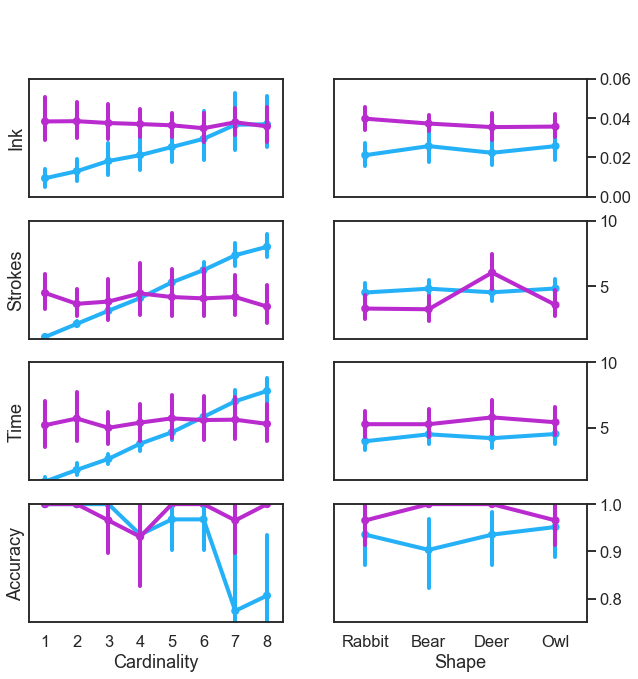

In [271]:
# Figure 2 produced as follows, showing each naive measure over cardinality & animal

# set what data we want to plot; this can be any trial block, or all blocks
num_data = df_num
aml_data = df_aml

## the legend, if ever we want to put it in
# number_patch = mpatches.Patch(color='#25B1F7', label='Number Games')
# animal_patch = mpatches.Patch(color='#B92BCF', label='Animal Games')
# plt.legend(handles=[number_patch, animal_patch])

# overall figure parameters
graph_size = (5,2)
card_fig = plt.figure("By Cardinality",figsize=(10,10))
# card_fig.suptitle("Figure 2 – DVs by Stimulus Feature")
card_fig.suptitle("        ")

ax1 = card_fig.add_subplot(4,2,1)
ax2 = card_fig.add_subplot(4,2,2)
ax3 = card_fig.add_subplot(4,2,3)
ax4 = card_fig.add_subplot(4,2,4)
ax5 = card_fig.add_subplot(4,2,5)
ax6 = card_fig.add_subplot(4,2,6)
ax7 = card_fig.add_subplot(4,2,7)
ax8 = card_fig.add_subplot(4,2,8)


# for all the odd subplots, plot out DVs over cardinality

# plt.figure("Ink over Cardinality",figsize=graph_size)
sns.pointplot(data=num_data, x='cardinality', y='meanPixelIntensity',color='#25B1F7',markers='.',ax=ax1)
sns.pointplot(data=aml_data, x='cardinality', y='meanPixelIntensity',color='#B92BCF',markers='.',ax=ax1)
# plt.title("Ink by Cardinality")
# plt.ylabel("Ink")
# plt.xlabel("")
# plt.xticks([])
# plt.show()

# plt.figure("Strokes over Cardinality",figsize=graph_size)
sns.pointplot(data=num_data, x='cardinality', y='numStrokes',color='#25B1F7',markers='.',ax=ax3)
sns.pointplot(data=aml_data, x='cardinality', y='numStrokes',color='#B92BCF',markers='.',ax=ax3)
# plt.title("Strokes by Cardinality")
# plt.ylabel("Strokes")
# plt.xlabel("")
# plt.xticks([])
# plt.show()

# plt.figure("Sketch Time over Cardinality",figsize=graph_size)
sns.pointplot(data=num_data, x='cardinality', y='drawDuration',color='#25B1F7',markers='.',ax=ax5)
sns.pointplot(data=aml_data, x='cardinality', y='drawDuration',color='#B92BCF',markers='.',ax=ax5)
# plt.title("Sketch Time by Cardinality")
# plt.ylabel("Sketch Time")
# plt.xlabel("")
# plt.xticks([])
# plt.show()

# plt.figure("Accuracy over Cardinality",figsize=graph_size)
sns.pointplot(data=num_data, x='cardinality', y='outcome',color='#25B1F7',markers='.',ax=ax7)
sns.pointplot(data=aml_data, x='cardinality', y='outcome',color='#B92BCF',markers='.',ax=ax7)
# plt.title("Accuracy by Cardinality")
# plt.ylabel("Accuracy")
# plt.xlabel("Cardinality")







# for all the even subplots, plot out DVs over animal

# plt.figure("Ink over Animal Type",figsize=graph_size)
sns.pointplot(data=num_data, x='category', y='meanPixelIntensity',color='#25B1F7',markers='.',ax=ax2)
sns.pointplot(data=aml_data, x='category', y='meanPixelIntensity',color='#B92BCF',markers='.',ax=ax2)
# plt.title("Ink by Animal Type")
# plt.ylabel("Ink")
# plt.xlabel("")
# plt.xticks([])
# plt.show()

# plt.figure("Strokes over Animal Type",figsize=graph_size)
sns.pointplot(data=num_data, x='category', y='numStrokes',color='#25B1F7',markers='.',ax=ax4)
sns.pointplot(data=aml_data, x='category', y='numStrokes',color='#B92BCF',markers='.',ax=ax4)
# plt.title("Strokes by Animal Type")
# plt.ylabel("Strokes")
# plt.xlabel("")
# plt.xticks([])
# plt.show()

# plt.figure("Sketch Time over Animal Type",figsize=graph_size)
sns.pointplot(data=num_data, x='category', y='drawDuration',color='#25B1F7',markers='.',ax=ax6)
sns.pointplot(data=aml_data, x='category', y='drawDuration',color='#B92BCF',markers='.',ax=ax6)
# plt.title("Sketch Time by Animal Type")
# plt.ylabel("Sketch Time")
# plt.xlabel("")
# plt.xticks([])
# plt.show()

# plt.figure("Accuracy over Animal Type",figsize=graph_size)
sns.pointplot(data=num_data, x='category', y='outcome',color='#25B1F7',markers='.',ax=ax8)
sns.pointplot(data=aml_data, x='category', y='outcome',color='#B92BCF',markers='.',ax=ax8)
# plt.title("Accuracy by Animal Type")
# plt.ylabel("Accuracy")
# plt.xlabel("Animal Type")

# Set the labels, ticks, and limits (note: limits are set to accommodate data averaged across blocks
# individual block data goes beyond the y limits set below)
ax1.set_ylabel("Ink")
ax3.set_ylabel("Strokes")
ax5.set_ylabel("Time")
ax7.set_ylabel("Accuracy")
ax2.set_ylabel("")
ax4.set_ylabel("")
ax6.set_ylabel("")
ax8.set_ylabel("")
ax1.set_yticks([])
ax3.set_yticks([])
ax5.set_yticks([])
ax7.set_yticks([])


ax1.set_xlabel("")
ax2.set_xlabel("")
ax3.set_xlabel("")
ax4.set_xlabel("")
ax5.set_xlabel("")
ax6.set_xlabel("")
ax7.set_xlabel("Cardinality")
ax8.set_xlabel("Shape")


ax1.set_xticks([])
ax2.set_xticks([])
ax3.set_xticks([])
ax4.set_xticks([])
ax5.set_xticks([])
ax6.set_xticks([])
ax7.set_xticklabels([1,2,3,4,5,6,7,8])
ax8.set_xticklabels(['Rabbit','Bear','Deer','Owl'])

ax1.set_ylim([0, .06])
ax2.set_ylim([0, .06])
ax3.set_ylim([1, 10])
ax4.set_ylim([1, 10])
ax5.set_ylim([1, 10])
ax6.set_ylim([1, 10])
ax7.set_ylim([.75, 1])
ax8.set_ylim([.75, 1])

ax2.yaxis.tick_right()
ax4.yaxis.tick_right()
ax6.yaxis.tick_right()
ax8.yaxis.tick_right()

plt.show()

### Figure 4: Correlations over Blocks

<function matplotlib.pyplot.show(*args, **kw)>

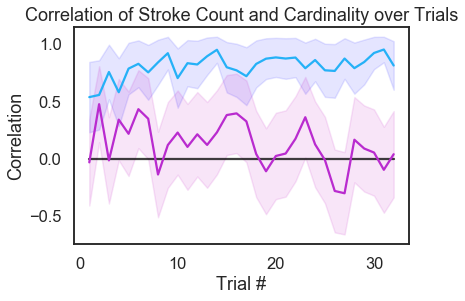

In [206]:
# Plot correlations by trial number (this does not make it into figure 4, but is interesting)
DV = 'numStrokes' # 'outcome', 'drawDuration', 'numStrokes', 'meanPixelIntensity'
num_corr_trials = []
aml_corr_trials = []

def corr_confint(corrcoef,N,tc=1.96):
    sr = np.sqrt((1-corrcoef**2)/(N-2))
    return sr*tc

for trialnum in np.arange(1,33):
    num_trial = df_num.loc[df_num['trialNum'] == trialnum]
    aml_trial = df_aml.loc[df_aml['trialNum'] == trialnum]
    num_corr_trial = stats.pearsonr(num_trial['cardinality'], num_trial[DV])[0]
    aml_corr_trial = stats.pearsonr(aml_trial['cardinality'], aml_trial[DV])[0]
    num_corr_trials.append(num_corr_trial)
    aml_corr_trials.append(aml_corr_trial)
    #num_confints.append()
    
    
num_corr_trials = np.array(num_corr_trials)
aml_corr_trials = np.array(aml_corr_trials)
    
num_confints = corr_confint(num_corr_trials, len(np.unique(df_num['gameID'])))
aml_confints = corr_confint(aml_corr_trials, len(np.unique(df_aml['gameID'])))

plt.figure("Correlations (line chart)")
plt.title("Correlation of Stroke Count and Cardinality over Trials")
plt.plot(np.arange(1,33),32*[0],color='black',alpha = .75)
plt.plot(np.arange(1,33),num_corr_trials,color='#25B1F7')
plt.plot(np.arange(1,33),aml_corr_trials,color='#B92BCF')
plt.fill_between(np.arange(1,33), (num_corr_trials-num_confints), (num_corr_trials+num_confints), color='b', alpha=.1)   
plt.fill_between(np.arange(1,33), (aml_corr_trials-aml_confints), (aml_corr_trials+aml_confints), color='m', alpha=.1)    
plt.ylabel("Correlation")
plt.xlabel("Trial #")
plt.show




In [9]:
# Plot correlations by block number
DV = 'numStrokes' # 'outcome', 'drawDuration', 'numStrokes', 'meanPixelIntensity'
num_corr_blocks = []
aml_corr_blocks = []

for blocknum in np.arange(1,5):
    num_block = df_num.loc[df_num['quarter'] == blocknum]
    aml_block = df_aml.loc[df_aml['quarter'] == blocknum]
    num_corr_block = stats.pearsonr(num_block['cardinality'], num_block[DV])[0]
    aml_corr_block = stats.pearsonr(aml_block['cardinality'], aml_block[DV])[0]
    num_corr_blocks.append(num_corr_block)
    aml_corr_blocks.append(aml_corr_block)
    
    
num_corr_blocks = np.array(num_corr_blocks)
aml_corr_blocks = np.array(aml_corr_blocks)

#make sure this is the right way to do N samples - it's total trials, so 8 per block times number of games
num_confints = corr_confint(num_corr_blocks, 8*len(np.unique(df_num['gameID'])))
aml_confints = corr_confint(aml_corr_blocks, 8*len(np.unique(df_aml['gameID'])))

plt.figure("Correlations (line chart)")
plt.title("Correlation of Accuracy and Cardinality over Blocks")
plt.plot(np.arange(1,5),4*[0],color='black',alpha = .5,linestyle='--')
plt.plot(np.arange(1,5),num_corr_blocks,color='#25B1F7')
plt.plot(np.arange(1,5),aml_corr_blocks,color='#B92BCF')
plt.fill_between(np.arange(1,5), (num_corr_blocks-num_confints), (num_corr_blocks+num_confints), color='#25B1F7', alpha=.1)   
plt.fill_between(np.arange(1,5), (aml_corr_blocks-aml_confints), (aml_corr_blocks+aml_confints), color='#B92BCF', alpha=.1)    
plt.ylabel("Correlation")
plt.xlabel("Block #")
plt.show




NameError: name 'df_num' is not defined

## Extra, not official things:

<function matplotlib.pyplot.show(*args, **kw)>

<Figure size 864x288 with 0 Axes>

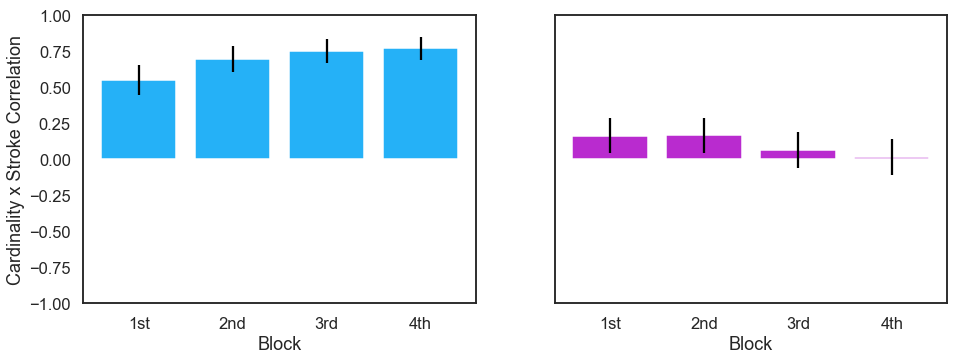

In [262]:
# print("All Games: \n", D[['cardinality','numStrokes']].corr())
# print("Number Games: \n", df_num[['cardinality','numStrokes']].corr())
# print("Animal Games: \n", df_aml[['cardinality','numStrokes']].corr())

dv = 'drawDuration' # 'outcome', 'drawDuration', 'numStrokes', 'meanPixelIntensity'


# Plotting correlation of Stroke Count and Cardinality by block number

num_corrs = np.array([#stats.pearsonr(df_num['cardinality'], df_num['numStrokes'])[0],
             stats.pearsonr(dn1['cardinality'], dn1[dv])[0],
             stats.pearsonr(dn2['cardinality'], dn2[dv])[0],
             stats.pearsonr(dn3['cardinality'], dn3[dv])[0],
             stats.pearsonr(dn4['cardinality'], dn4[dv])[0]])

num_confints = corr_confint(num_corrs,len(dn1))

aml_corrs = np.array([#stats.pearsonr(df_aml['cardinality'], df_aml['numStrokes'])[0],
             stats.pearsonr(da1['cardinality'], da1[dv])[0],
             stats.pearsonr(da2['cardinality'], da2[dv])[0],
             stats.pearsonr(da3['cardinality'], da3[dv])[0],
             stats.pearsonr(da4['cardinality'], da4[dv])[0]])

aml_confints = corr_confint(aml_corrs,len(dn1))

# plt.figure("Correlations (line chart)")
# plt.title("Correlation of Stroke Count and Cardinality in each Block")
# plt.plot(np.arange(1,5),[0,0,0,0],color='black',alpha = .75)
# plt.plot(np.arange(1,5),num_corrs,color='#25B1F7')
# plt.plot(np.arange(1,5),aml_corrs,color='#B92BCF')
# plt.fill_between(np.arange(1,5), (num_corrs-num_confints), (num_corrs+num_confints), color='b', alpha=.1)   
# plt.fill_between(np.arange(1,5), (aml_corrs-aml_confints), (aml_corrs+aml_confints), color='m', alpha=.1)    
# plt.ylabel("Correlation")
# plt.xlabel("Block")
# number_patch = mpatches.Patch(color='#25B1F7', label='Number Games')
# animal_patch = mpatches.Patch(color='#B92BCF', label='Animal Games')
# plt.legend(handles=[number_patch, animal_patch])
# plt.show


plt.figure("Correlations (bar chart)",figsize=(12, 4))
plt.suptitle("Correlations between Cardinality and DV by Block")
fig, (ax1, ax2) = plt.subplots(1,2)
# fig.suptitle("Correlation of Stroke Count and Cardinality by Block Number")
ax1.bar(np.arange(1,5),num_corrs,color='#25B1F7',yerr=num_confints)
ax1.set_ylim([-1, 1])
ax2.bar(np.arange(1,5),aml_corrs,color='#B92BCF',yerr=aml_confints)
ax2.set_ylim([-1, 1])
ax2.set_yticks([], [])

ax1.set_xticks([1,2,3,4])
ax1.set_xticklabels(['1st','2nd','3rd','4th'])
ax2.set_xticks([1,2,3,4])
ax2.set_xticklabels(['1st','2nd','3rd','4th'])


ax1.set_ylabel("Cardinality x Stroke Correlation")
ax1.set_xlabel("Block")
ax2.set_xlabel("Block")
plt.subplots_adjust(left=1,right=3,bottom=1,top=2,wspace=.2,hspace=.2)

plt.show()

### Additional derived measures we might want

In [ ]:
# # Just trials where all distractors were of different animal category than the target
# D_animal = D.loc[(D['category'] != D['D1_Cat']) & (D['category'] != D['D2_Cat']) & (D['category'] != D['D3_Cat'])]
# D_animal[['trialNum','category','cardinality','D1_Cat','D1_Car','D2_Cat','D2_Car','D3_Cat','D3_Car']]


# to get differences between 1st and 3rd
# D1_sorted = D_1st.sort_values('cardinality')[['cardinality','meanPixelIntensity']].to_numpy()
# D4_sorted = D_4th.sort_values('cardinality')[['cardinality','meanPixelIntensity']].to_numpy()

# D_diff = pd.DataFrame({'cardinality': D1_sorted[:,0],
#                        'pixelIntensityDiff': D1_sorted[:,1] - D4_sorted[:,1]})


# General purpose function for plotting measurements separately by quarter of the experiment
def PlotByQuarter(title, d, xvar='cardinality',yvar='numStrokes',ylabel='Strokes per Sketch',cond='all',subp=None):
    if xvar=='cardinality':
        xlabel = 'Cardinality'
    elif xvar=='category':
        xlabel = 'Animal'
    
    if cond == 'all':
        df = d
    else:
        df = d.loc[d['Game_Condition'] == cond]
        
    D_1st = df.loc[df['quarter'] == 1.0]
    D_2nd = df.loc[df['quarter'] == 2.0]
    D_3rd = df.loc[df['quarter'] == 3.0]
    D_4th = df.loc[df['quarter'] == 4.0]
    
#     plt.figure(title)
#     plt.title(title)
    sns.pointplot(data=D_1st, x=xvar, y=yvar,color='#000000',markers='.',ax=subp).set_title(title)
    sns.pointplot(data=D_2nd, x=xvar, y=yvar,color='#960202',markers='.',ax=subp) #bb3f3f
    sns.pointplot(data=D_3rd, x=xvar, y=yvar,color='#D57810',markers='.',ax=subp) #edda07
    sns.pointplot(data=D_4th, x=xvar, y=yvar,color='#EDC917',markers='.',ax=subp) #6a0dad
#     sns.pointplot(data=df, x=xvar, y=yvar,color='#25B1F7',markers='.', ax=subp, linestyles='--').set_title(title) # average all
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    black_patch = mpatches.Patch(color='#000000', label='1st block')
    red_patch = mpatches.Patch(color='#960202', label='2nd block')
    yellow_patch = mpatches.Patch(color='#D57810', label='3rd block')
    purple_patch = mpatches.Patch(color='#EDC917', label='4th block')
    blue_patch = mpatches.Patch(color='#25B1F7', label='Average')
#     plt.legend(handles=[black_patch, red_patch, yellow_patch, purple_patch, blue_patch])

# PlotByQuarter("Ink by Cardinality",D,yvar='meanPixelIntensity',ylabel="Mean Pixel Intensity")
# PlotByQuarter("Strokes per Sketch",D,yvar='numStrokes',ylabel="Strokes per Sketch")
# PlotByQuarter("Curves per Stroke",D,yvar='numCurvesPerStroke',ylabel="Curves per Stroke")

# PlotByQuarter("Curves per Stroke (Animal)",D,xvar='category',yvar='numCurvesPerStroke',ylabel="Curves per Stroke")
# PlotByQuarter("Strokes per Sketch (Animal)",D,xvar='category',yvar='numStrokes',ylabel="Strokes per Sketch")

# PlotByQuarter("Mean Stroke Length by Cardinality",D,yvar='stroke_len_means',ylabel="Mean Stroke Length")
# PlotByQuarter("Sketch Time by Cardinality",D,yvar='drawDuration',ylabel="Sketch Time")

print('Done')


In [ ]:
# Plot data for just shape condition
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

PlotByQuarter("Ink by Cardinality",D,yvar='meanPixelIntensity',ylabel="Mean Pixel Intensity",cond='shape',subp=ax1)
PlotByQuarter("Strokes per Sketch",D,yvar='numStrokes',ylabel="Strokes per Sketch",cond='shape',subp=ax2)

PlotByQuarter("Draw Time by Cardinality",D,yvar='drawDuration',ylabel="Draw Time",cond='shape',subp=ax3)
PlotByQuarter("Accuracy by Cardinality",D,yvar='outcome',ylabel="Acc",cond='shape',subp=ax4)

plt.subplots_adjust(left=1,right=4,bottom=1,top=3,wspace=.2,hspace=.3)


In [ ]:
# Plot data for just number condition
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

PlotByQuarter("Ink by Cardinality",D,yvar='meanPixelIntensity',ylabel="Mean Pixel Intensity",cond='number',subp=ax1)
PlotByQuarter("Strokes per Sketch",D,yvar='numStrokes',ylabel="Strokes per Sketch",cond='number',subp=ax2)

PlotByQuarter("Draw Time by Cardinality",D,yvar='drawDuration',ylabel="Draw Time",cond='number',subp=ax3)
PlotByQuarter("Accuracy by Cardinality",D,yvar='outcome',ylabel="Acc",cond='number',subp=ax4)

plt.subplots_adjust(left=1,right=4,bottom=1,top=3,wspace=.2,hspace=.3)


In [ ]:
# Plot data for just shape condition
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

PlotByQuarter("Ink by Cardinality",D,yvar='meanPixelIntensity',ylabel="Mean Pixel Intensity",cond='all',subp=ax1)
PlotByQuarter("Strokes per Sketch",D,yvar='numStrokes',ylabel="Strokes per Sketch",cond='all',subp=ax2)

PlotByQuarter("Draw Time by Cardinality",D,yvar='drawDuration',ylabel="Draw Time",cond='all',subp=ax3)
PlotByQuarter("Accuracy by Cardinality",D,yvar='outcome',ylabel="Acc",cond='all',subp=ax4)


plt.subplots_adjust(left=1,right=4,bottom=1,top=3,wspace=.2,hspace=.3)


In [277]:
D['drawDuration'] = pd.to_numeric(D['drawDuration'])
acc_table = D.groupby('gameID')['drawDuration'].mean().reset_index()


In [ ]:
# for some reason, .mean() doesn't work on these. But .sum() and .count() do, so gonna use that
x = D.groupby(['cardinality'])[['cardinality','numCurvesPerStroke']].sum()
y = D.groupby(['cardinality'])[['cardinality','numCurvesPerStroke']].count()

print(x/y)
#sns.pointplot(data=D, x='trialNum', y='numCurvesPerStroke')
sns.pointplot(data=D, x='trialNum', y='numStrokes')


### Measures of iconicity:

In [ ]:
# Complexity (number of curves) and ink (pixel intensity) per cardinality and between animals

plt.figure()
sns.barplot(data=D, x='cardinality', y='numStrokes')
plt.figure()
sns.barplot(data=D, x='cardinality', y='numCurvesPerSketch')
plt.figure()
sns.barplot(data=D, x='cardinality', y='meanPixelIntensity')

In [ ]:
plt.figure()
sns.barplot(data=D, x='category', y='numStrokes')
plt.figure()
sns.barplot(data=D, x='category', y='numCurvesPerSketch')
plt.figure()
sns.barplot(data=D, x='category', y='meanPixelIntensity')

In [ ]:
# linear regression....


#stats.linregress(D.groupby('cardinality')['drawDuration'])
D.groupby(['cardinality'])[['quarter','drawDuration']]


In [ ]:

plt.figure("Latent Space",figsize=(8, 4))
plt.title("Abstract Feature Clusters (Shape Game)")
plt.ylabel("Four-ish                Five-ish")
plt.xlabel("Owl-ish                                                  Bear-ish")
plt.yticks([])
plt.xticks([])
plt.show()


In [10]:
## Notes to Self:

# # If you ever want to see how many unique levels there are in mongodb coll
# w = coll.find({'iterationName':iterationName, 'eventType':'survey'})
# W = pd.DataFrame(w)
# coll.distinct('eventType')
